Jane, our friend at the bird-watching club, has set up a fleet of cameras in the woods
south of the airport. The cameras are supposed to save a shot when something enters
the frame and upload it to the club’s real-time bird-watching blog. The problem is
that a lot of planes coming and going from the airport end up triggering the camera. so Jane spends a lot of time deleting pictures of airplanes from the blog. What she
needs is an automated system that throws away the airplane.

In [1]:
import torch
from torch.utils.data import DataLoader
from torch import optim
from torchvision import datasets
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os

In [2]:
train=datasets.CIFAR10(root='data',
                      train=True,
                      download=True,
                      transform=transforms.ToTensor())

Extracting data/cifar-10-python.tar.gz to data


In [3]:
test=datasets.CIFAR10(root='data',
                      train=False,
                      download=True,
                      transform=transforms.ToTensor())

Files already downloaded and verified


In [4]:
label_class={
0:'airplane',
1:'automobile',
2:'bird',
3:'cat',
4:'deer',
5:'dog',
6:'frog',
7:'horse',
8:'ship',
9:'truck'
}

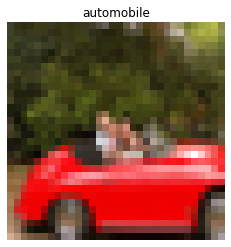

In [5]:
img,label=train[99]
plt.title(label_class[label])
plt.axis('off')
plt.imshow(img.permute(1,2,0))

In [6]:
img.shape

torch.Size([3, 32, 32])

Since we only need airplane and birds from the Cifar10 dataset which contains 10 different item images, we are going to select only the birds and airplane data from the dataset.

In [7]:
label_map = {0: 0, 2: 1}
cifar_2_train=[(img,label_map[label]) for img,label in train if label in [0,2]]
cifar_2_test=[(img,label_map[label]) for img,label in test if label in [0,2]]

In [8]:
train_loader=DataLoader(cifar_2_train, batch_size=64,shuffle=True)

In [65]:
device=(torch.device('cuda') if torch.cuda.is_available() 
        else torch.device('cpu'))

In [40]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [44]:
model = Net()

In [47]:
optimizer=optim.SGD(model.parameters(),1e-4)
loss_fn=nn.CrossEntropyLoss()

In [46]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1,n_epochs+1):
        loss_train = 0.0
        for imgs,labels in train_loader:
            imgs=imgs.to(device=device)
            labels = labels.to(device=device)
            output=model(imgs)
            loss=loss_fn(output, torch.tensor(labels))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch%10==0 or epoch==1:
            print("Epoch: %d, Loss: %f" % (epoch, float(loss_train / len(train_loader))))

In [48]:
training_loop(
n_epochs = 100,
optimizer = optimizer,
model = model,
loss_fn = loss_fn,
train_loader = train_loader,
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Epoch: 1, Loss: 0.694157
Epoch: 10, Loss: 0.691412
Epoch: 20, Loss: 0.688506
Epoch: 30, Loss: 0.685745
Epoch: 40, Loss: 0.682796
Epoch: 50, Loss: 0.679491
Epoch: 60, Loss: 0.675218
Epoch: 70, Loss: 0.670293
Epoch: 80, Loss: 0.664348
Epoch: 90, Loss: 0.656831
Epoch: 100, Loss: 0.647857


In [49]:
test_loader=DataLoader(cifar_2_test,batch_size=64,shuffle=False)

In [54]:
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in test_loader:
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
print("Accuracy: %f", correct / total)

Accuracy: %f 0.8345


So our new version has an accuracy of 78% in detecting birds and airplane accurately. We are  improving :)

Lets save the model

In [56]:
torch.save(model.state_dict(), './' + 'birds_vs_airplanes.pt')

To load the model,

In [ ]:
loaded_model=Net()
loaded_model.load_state_dict(torch.load('./'+ 'birds_vs_airplanes.pt'))